# Visualizing Results

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import pickle
import json
import os 

## Plotting Dadi vs Moments

In [2]:
# Plot dadi vs moments inferences for bottleneck experiment - CORRECTED VERSION
import pickle
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

experiment_name = 'drosophila_three_epoch'

# Load data from all_inferences.pkl files across simulations
exp_root = Path(f'/projects/kernlab/akapoor/kernlab/Infer_Demography/experiments/{experiment_name}')
sim_dirs = sorted([d for d in exp_root.glob('inferences/sim_*') if d.is_dir()])

# Limit the number of simulations for faster processing (optional)
max_sims = 5000  # Set to None to use all simulations
if max_sims is not None:
    sim_dirs = sim_dirs[:max_sims]

dadi_estimates = {}
moments_estimates = {}
true_params = {}

print(f"Processing {len(sim_dirs)} simulations...")

# Collect data from all simulations
for i, sim_dir in enumerate(sim_dirs):
    if i % 100 == 0:  # Progress indicator
        print(f"Processed {i}/{len(sim_dirs)} simulations...")
        
    sim_id = sim_dir.name.split('_')[1]  # Extract sim number
    all_inferences_file = sim_dir / 'all_inferences.pkl'
    true_params_file = exp_root / f'simulations/{sim_id}/sampled_params.pkl'
    
    if all_inferences_file.exists() and true_params_file.exists():
        try:
            # Load inferences
            with open(all_inferences_file, 'rb') as f:
                all_inferences = pickle.load(f)
            
            # Load true parameters
            with open(true_params_file, 'rb') as f:
                true_vals = pickle.load(f)
            
            # Extract dadi and moments parameters - CORRECTED FOR LIST FORMAT
            if 'dadi' in all_inferences and 'moments' in all_inferences:
                dadi_params = all_inferences['dadi']['best_params']
                moments_params = all_inferences['moments']['best_params']
                
                # Handle list of parameter dictionaries (take the best/first one)
                if isinstance(dadi_params, list) and len(dadi_params) > 0:
                    dadi_best = dadi_params[0]  # Take first (best) fit
                else:
                    dadi_best = dadi_params
                    
                if isinstance(moments_params, list) and len(moments_params) > 0:
                    moments_best = moments_params[0]  # Take first (best) fit  
                else:
                    moments_best = moments_params
                
                if isinstance(dadi_best, dict) and isinstance(moments_best, dict):
                    # Find common parameters between both methods
                    common_param_names = set(dadi_best.keys()) & set(moments_best.keys())
                    
                    for param in common_param_names:
                        if param not in dadi_estimates:
                            dadi_estimates[param] = []
                            moments_estimates[param] = []
                            true_params[param] = []
                        
                        dadi_estimates[param].append(dadi_best[param])
                        moments_estimates[param].append(moments_best[param])
                        true_params[param].append(true_vals.get(param, np.nan))
                        
        except Exception as e:
            print(f"Error loading sim {sim_id}: {e}")
            continue

# Get common parameters
common_params = sorted(set(dadi_estimates.keys()) & set(moments_estimates.keys()) & set(true_params.keys()))
print(f"Common parameters found: {common_params}")
print(f"Number of simulations loaded: {len(dadi_estimates.get(common_params[0], []))}")

# Create plots with fixed colorbar layout
n_params = len(common_params)
if n_params > 0:
    # Create figure with constrained layout for better spacing
    fig = plt.figure(figsize=(4 * n_params + 2, 4), constrained_layout=True)
    
    # Create a gridspec with space for colorbar
    gs = fig.add_gridspec(1, n_params + 1, width_ratios=[1] * n_params + [0.05])
    
    # Create subplots for the scatter plots
    axes = []
    for i in range(n_params):
        ax = fig.add_subplot(gs[0, i])
        axes.append(ax)
    
    # Store scatter plot for colorbar reference
    scatter_plots = []
    
    for i, param in enumerate(common_params):
        ax = axes[i]
        x = np.array(dadi_estimates[param])
        y = np.array(moments_estimates[param])
        true_vals = np.array(true_params[param])
        
        # Create scatter plot colored by true values
        scatter = ax.scatter(x, y, c=true_vals, cmap='viridis', s=30, alpha=0.8)
        scatter_plots.append(scatter)
        
        # Add 1:1 line
        min_val = min(x.min(), y.min())
        max_val = max(x.max(), y.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1, label='1:1 line')
        
        ax.set_xlabel(f'dadi {param}')
        ax.set_ylabel(f'moments {param}')
        ax.set_title(f'{param}')
        ax.grid(True, alpha=0.3)

    # Create colorbar in dedicated subplot
    cbar_ax = fig.add_subplot(gs[0, -1])
    cbar = fig.colorbar(scatter_plots[0], cax=cbar_ax, label='True parameter value')
    
    plt.suptitle(f'dadi vs moments parameter inferences ({experiment_name} experiment)', fontsize=14)
    plt.show()
else:
    print("No common parameters found to plot")

Processing 0 simulations...
Common parameters found: []


IndexError: list index out of range

## Validation MSE across models and by parameter

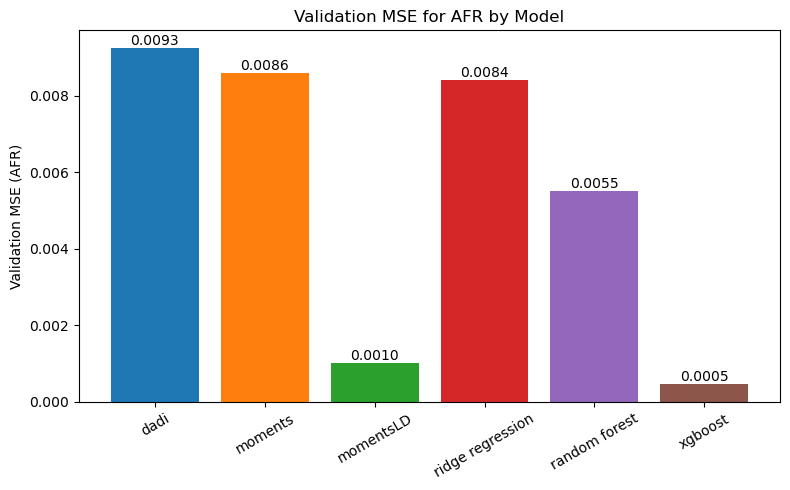

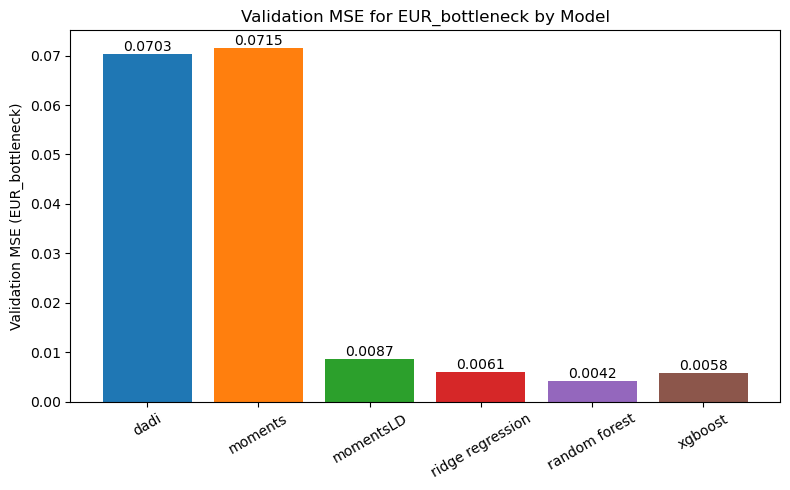

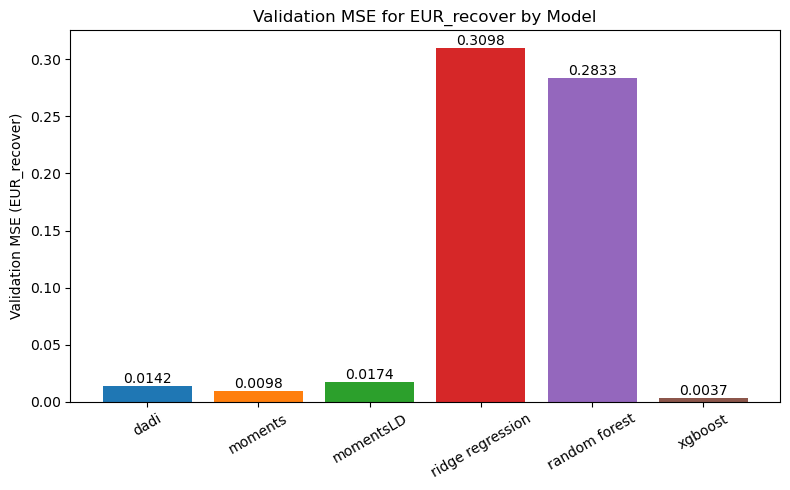

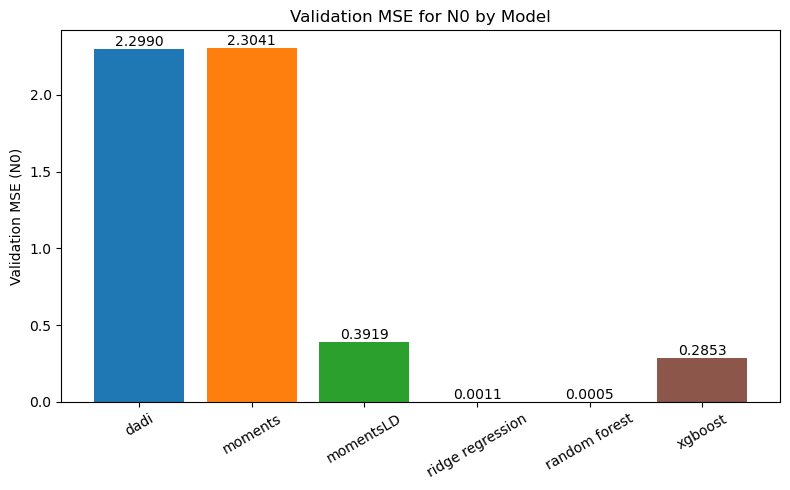

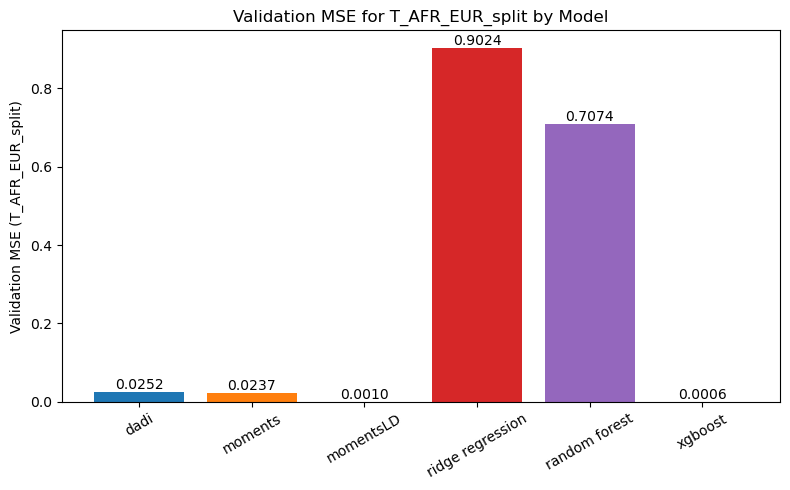

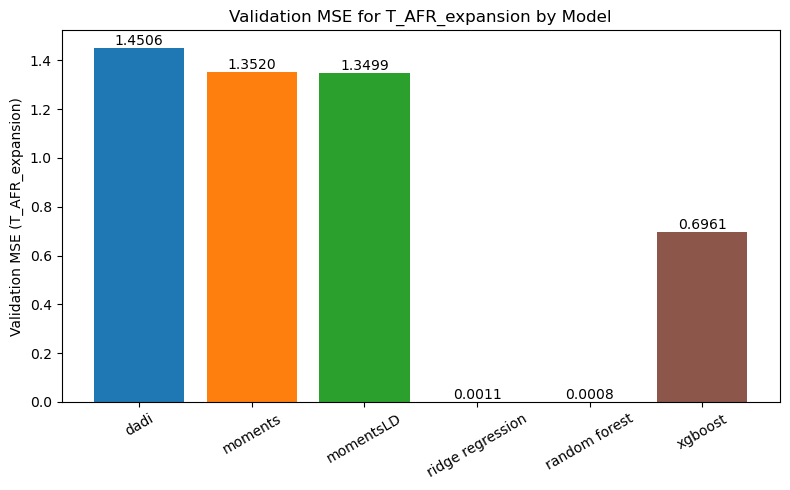

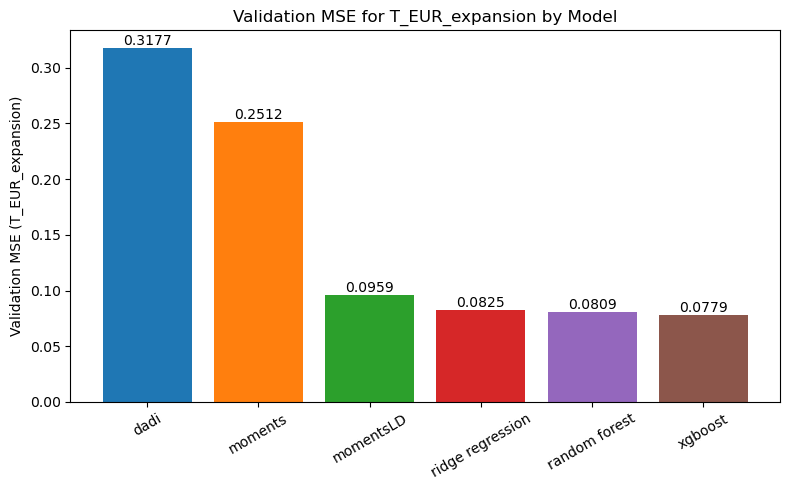

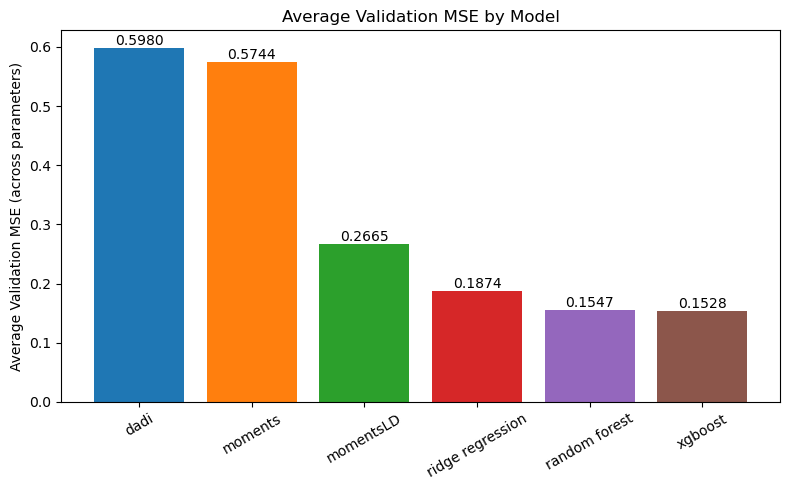

In [4]:
# Bar chart of validation MSE for all demographic parameters with fixed model order
import json
import matplotlib.pyplot as plt
import numpy as np

experiment_name = 'drosophila_three_epoch'
model_type = 'modeling'

metrics_path = f'/projects/kernlab/akapoor/Infer_Demography/experiments/{experiment_name}/{model_type}/datasets/metrics_all.json'
ridge_path = f'/projects/kernlab/akapoor/Infer_Demography/experiments/{experiment_name}/{model_type}/linear_ridge/linear_model_error_ridge.json'
rf_path = f'/projects/kernlab/akapoor/Infer_Demography/experiments/{experiment_name}/{model_type}/random_forest/random_forest_model_error.json'
xgb_path = f'/projects/kernlab/akapoor/Infer_Demography/experiments/{experiment_name}/{model_type}/xgboost/xgb_model_error.json'
with open(metrics_path) as f:
    metrics = json.load(f)
with open(ridge_path) as f:
    ridge = json.load(f)
with open(rf_path) as f:
    rf = json.load(f)
with open(xgb_path) as f:
    xgb = json.load(f)

# Fixed model order and display names
models = ['dadi', 'moments', 'momentsLD', 'ridge', 'random_forest', 'xgboost']
display_names = ['dadi', 'moments', 'momentsLD', 'ridge regression', 'random forest', 'xgboost']
model_dicts = [metrics['dadi'], metrics['moments'], metrics['momentsLD'], ridge, rf, xgb]

# Get all demographic parameters from one of the validation_mse dicts (assuming all have same keys)
param_keys = set()
for m_dict in model_dicts:
    if 'validation_mse' in m_dict:
        param_keys.update(m_dict['validation_mse'].keys())
param_keys = sorted(param_keys)

for param in param_keys:
    mse_dict = {}
    for model, m_dict in zip(models, model_dicts):
        val = m_dict.get('validation_mse', {}).get(param, None)
        mse_dict[model] = val

    # Use fixed order
    ordered_mse = [mse_dict[m] for m in models]

    plt.figure(figsize=(8,5))
    bars = plt.bar(display_names, ordered_mse, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
    plt.ylabel(f'Validation MSE ({param})')
    plt.title(f'Validation MSE for {param} by Model')
    plt.xticks(rotation=30)

    # Annotate values
    for i, v in enumerate(ordered_mse):
        plt.text(i, v if v is not None else 0.01, f'{v:.4f}' if v is not None else 'Missing', ha='center', va='bottom', color='black', fontsize=10)

    plt.tight_layout()
    plt.show()

# Rolled-up bar chart: average MSE per method across all parameters
avg_mse = []
for model, m_dict in zip(models, model_dicts):
    vals = list(m_dict.get('validation_mse', {}).values())
    vals = [v for v in vals if v is not None]
    avg = np.mean(vals) if vals else np.nan
    avg_mse.append(avg)

plt.figure(figsize=(8,5))
bars = plt.bar(display_names, avg_mse, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
plt.ylabel('Average Validation MSE (across parameters)')
plt.title('Average Validation MSE by Model')
plt.xticks(rotation=30)

for i, v in enumerate(avg_mse):
    plt.text(i, v if not np.isnan(v) else 0.01, f'{v:.4f}' if not np.isnan(v) else 'Missing', ha='center', va='bottom', color='black', fontsize=10)

plt.tight_layout()
plt.show()

In [15]:
# Table of validation MSEs: methods as columns, parameters as rows
import json
import pandas as pd

experiment_name = 'bottleneck'

metrics_path = f'/home/akapoor/kernlab/Infer_Demography/experiments/{experiment_name}/modeling/datasets/metrics_all.json'
ridge_path = f'/home/akapoor/kernlab/Infer_Demography/experiments/{experiment_name}/modeling/linear_ridge/linear_model_error_ridge.json'
rf_path = f'/home/akapoor/kernlab/Infer_Demography/experiments/{experiment_name}/modeling/random_forest/random_forest_model_error.json'
xgb_path = f'/home/akapoor/kernlab/Infer_Demography/experiments/{experiment_name}/modeling/xgboost/xgb_model_error.json'

with open(metrics_path) as f:
    metrics = json.load(f)
with open(ridge_path) as f:
    ridge = json.load(f)
with open(rf_path) as f:
    rf = json.load(f)
with open(xgb_path) as f:
    xgb = json.load(f)

# Fixed model order and display names
models = ['dadi', 'moments', 'momentsLD', 'ridge', 'random_forest', 'xgboost']
display_names = ['dadi', 'moments', 'momentsLD', 'ridge regression', 'random forest', 'xgboost']
model_dicts = [metrics['dadi'], metrics['moments'], metrics['momentsLD'], ridge, rf, xgb]

# Get all demographic parameters from one of the validation_mse dicts (assuming all have same keys)
param_keys = set()
for m_dict in model_dicts:
    if 'validation_mse' in m_dict:
        param_keys.update(m_dict['validation_mse'].keys())
param_keys = sorted(param_keys)

# Build table
table = []
for param in param_keys:
    row = []
    for m_dict in model_dicts:
        val = m_dict.get('validation_mse', {}).get(param, None)
        row.append(val)
    table.append(row)

df = pd.DataFrame(table, index=param_keys, columns=display_names)
df_display = df.round(4).fillna('Missing')
df_display

FileNotFoundError: [Errno 2] No such file or directory: '/home/akapoor/kernlab/Infer_Demography/experiments/bottleneck/modeling/datasets/metrics_all.json'

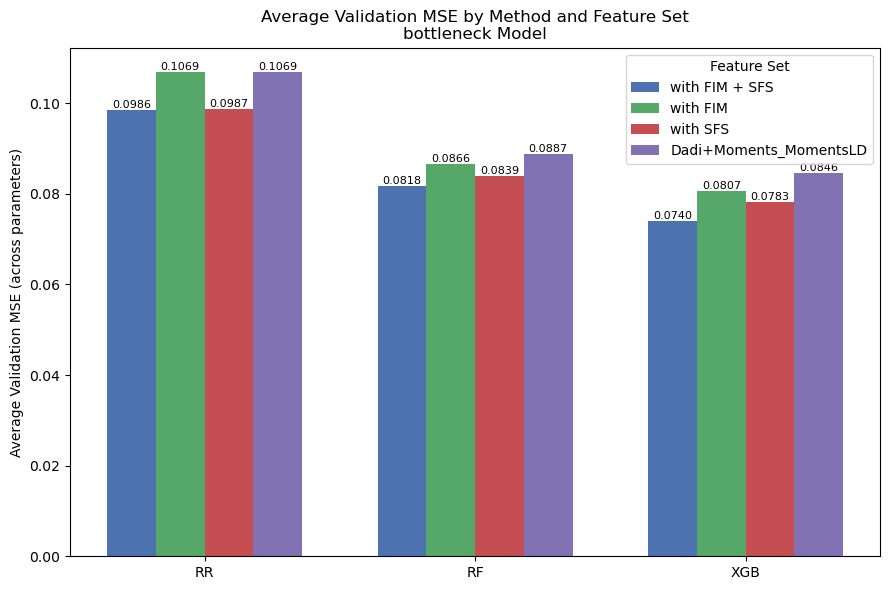

In [16]:
import json, os
import matplotlib.pyplot as plt
import numpy as np

experiment_name = 'bottleneck'
# Set to 'constrained_analysis' if you want to look at constrained analysis results, otherwise leave as None
analysis_type = None  # Change to 'constrained_analysis' if needed

# Construct the base path with optional analysis type
if analysis_type:
    base = f"/projects/kernlab/akapoor/Infer_Demography/experiments/{experiment_name}/{analysis_type}"
    title_suffix = f" ({analysis_type})"
else:
    base = f"/projects/kernlab/akapoor/Infer_Demography/experiments/{experiment_name}"
    title_suffix = ""

paths = {
    "RR_FIM_SFS":  f"{base}/modeling_w_FIM_w_SFSresids/linear_ridge/linear_model_error_ridge.json",
    "RR_FIM":      f"{base}/modeling_w_FIM_wo_SFSresids/linear_ridge/linear_model_error_ridge.json",
    "RR_SFS":      f"{base}/modeling_wo_FIM_w_SFSresids/linear_ridge/linear_model_error_ridge.json",
    "RR_BASE":     f"{base}/modeling_wo_FIM_wo_SFSresids/linear_ridge/linear_model_error_ridge.json",

    "RF_FIM_SFS":  f"{base}/modeling_w_FIM_w_SFSresids/random_forest/random_forest_model_error.json",
    "RF_FIM":      f"{base}/modeling_w_FIM_wo_SFSresids/random_forest/random_forest_model_error.json",
    "RF_SFS":      f"{base}/modeling_wo_FIM_w_SFSresids/random_forest/random_forest_model_error.json",
    "RF_BASE":     f"{base}/modeling_wo_FIM_wo_SFSresids/random_forest/random_forest_model_error.json",

    "XGB_FIM_SFS": f"{base}/modeling_w_FIM_w_SFSresids/xgboost/xgb_model_error.json",
    "XGB_FIM":     f"{base}/modeling_w_FIM_wo_SFSresids/xgboost/xgb_model_error.json",
    "XGB_SFS":     f"{base}/modeling_wo_FIM_w_SFSresids/xgboost/xgb_model_error.json",
    "XGB_BASE":    f"{base}/modeling_wo_FIM_wo_SFSresids/xgboost/xgb_model_error.json",
}

def load_avg_mse(path):
    if not os.path.exists(path):
        return np.nan
    with open(path, "r") as f:
        data = json.load(f)
    vals = [v for v in data.get("validation_mse", {}).values() if v is not None]
    return float(np.mean(vals)) if vals else np.nan

methods = ["RR", "RF", "XGB"]
labels  = ["with FIM + SFS", "with FIM", "with SFS", "Dadi+Moments_MomentsLD"]

# collect MSEs for each model and condition
results = []
for m in methods:
    mses = [
        load_avg_mse(paths[f"{m}_FIM_SFS"]),
        load_avg_mse(paths[f"{m}_FIM"]),
        load_avg_mse(paths[f"{m}_SFS"]),
        load_avg_mse(paths[f"{m}_BASE"])
    ]
    results.append(mses)
results = np.array(results)

# plotting
x = np.arange(len(methods))
width = 0.18
fig, ax = plt.subplots(figsize=(9,6))

offsets = np.linspace(-1.5*width, 1.5*width, 4)
colors  = ["#4C72B0", "#55A868", "#C44E52", "#8172B3"]

for i in range(4):
    bars = ax.bar(x + offsets[i], results[:, i], width, label=labels[i], color=colors[i])
    for j in range(len(methods)):
        val = results[j, i]
        if not np.isnan(val):
            ax.text(x[j] + offsets[i], val, f"{val:.4f}",
                    ha="center", va="bottom", fontsize=8)

ax.set_ylabel("Average Validation MSE (across parameters)")
ax.set_title(f"Average Validation MSE by Method and Feature Set\n{experiment_name}{title_suffix} Model")
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend(title="Feature Set")
plt.tight_layout()
plt.show()


In [1]:
import pickle 
with open('/sietch_colab/akapoor/Infer_Demography/experiments/split_isolation/modeling_w_FIM_w_SFSresids/random_forest/random_forest_mdl_obj.pkl', 'rb') as f:
    model = pickle.load(f)

## Plotting Barplots of BGS coverage percentage against MSE for each model

Number of validation sims: 901
Rows in df after dropping NaN coverage: 901


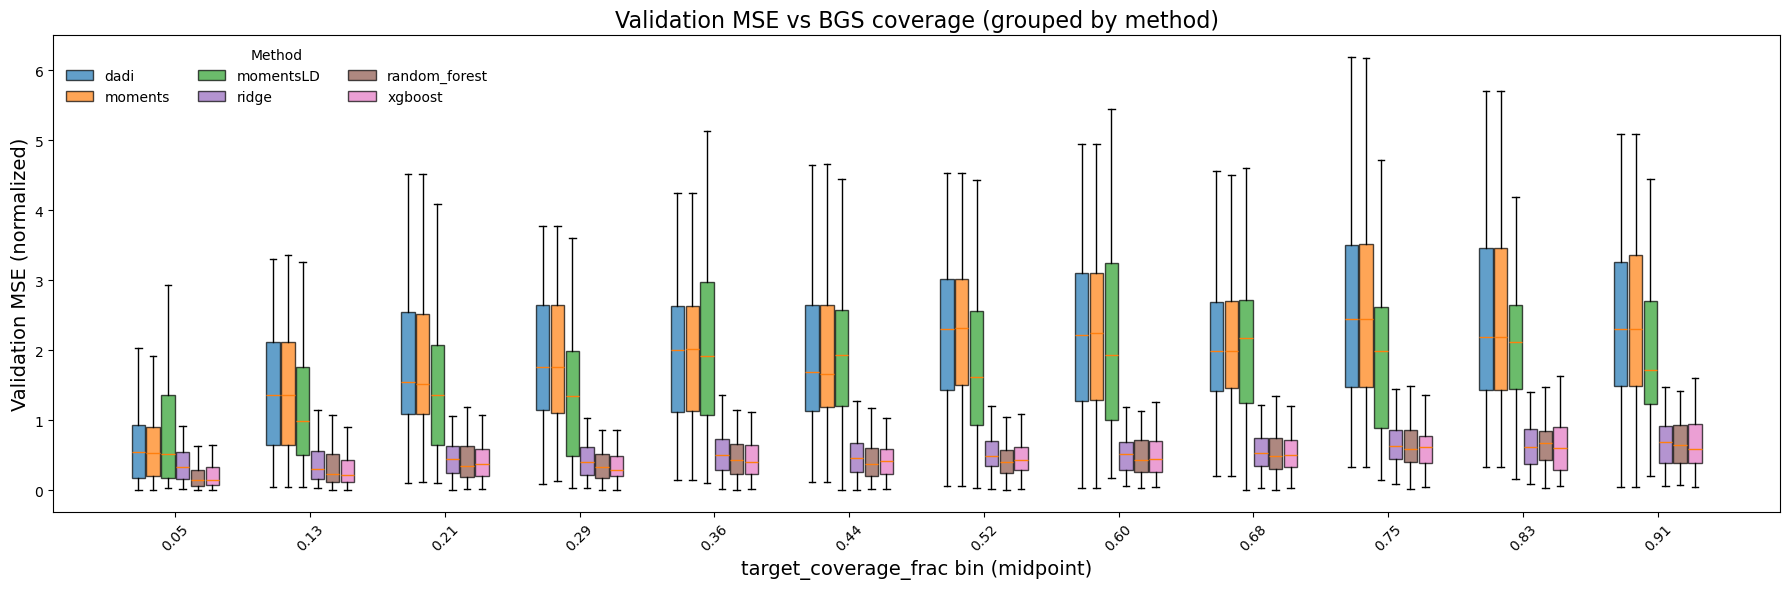

In [1]:
import json
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------------
# 1. Load validation features to get sim IDs
# ------------------------------------------------------------------------------

model = 'bottleneck'
model_type = 'modeling_wo_FIM_wo_SFSresids'

val_feat_path = f"/home/akapoor/kernlab/Infer_Demography/experiments_BGS/{model}/{model_type}/datasets/validation_features.pkl"
with open(val_feat_path, "rb") as f:
    validation_features = pickle.load(f)

validation_sim_ids = validation_features.index.to_numpy()
print("Number of validation sims:", len(validation_sim_ids))

# ------------------------------------------------------------------------------
# 2. Extract BGS coverage (target_coverage_frac)
# ------------------------------------------------------------------------------
coverage_vals = []
for sid in validation_sim_ids:
    meta_path = Path(f"/home/akapoor/kernlab/Infer_Demography/experiments_BGS/{model}/simulations/{sid}/bgs.meta.json")
    if meta_path.exists():
        with open(meta_path) as fh:
            meta = json.load(fh)
        coverage_vals.append(meta.get("target_coverage_frac", np.nan))
    else:
        coverage_vals.append(np.nan)

coverage_vals = np.array(coverage_vals)

# ------------------------------------------------------------------------------
# 3. Recompute per-sim MSE for dadi / moments / momentsLD (normalized space)
# ------------------------------------------------------------------------------
datasets_dir = Path(f"/home/akapoor/kernlab/Infer_Demography/experiments_BGS/{model}/{model_type}/datasets")

with open(datasets_dir / "normalized_validation_features.pkl", "rb") as f:
    X_val = pickle.load(f)

with open(datasets_dir / "normalized_validation_targets.pkl", "rb") as f:
    y_val = pickle.load(f)

param_names = list(y_val.columns)
all_cols = X_val.columns

import re

def tool_cols(tool, param):
    """All replicate columns for dadi/moments, or single for momentsLD."""
    pat = re.compile(rf"^{re.escape(tool)}_{re.escape(param)}(?:_rep_\d+)?$")
    return [c for c in all_cols if pat.match(c)]

def mse_for_tool(tool):
    """Per-simulation MSE (avg squared error across params)."""
    mse_list = []
    for sid in validation_sim_ids:
        se_sum, n = 0.0, 0
        for p in param_names:
            cols = tool_cols(tool, p)
            if not cols:
                continue
            preds = X_val.loc[sid, cols].to_numpy(float)
            preds = preds[~np.isnan(preds)]
            if preds.size == 0:
                continue
            pred_mean = preds.mean()
            true_val = float(y_val.loc[sid, p])
            se_sum += (pred_mean - true_val) ** 2
            n += 1
        mse_list.append(se_sum / n if n > 0 else np.nan)
    return np.array(mse_list, dtype=float)

mse_dadi      = mse_for_tool("dadi")
mse_moments   = mse_for_tool("moments")
mse_momentsLD = mse_for_tool("momentsLD")

# ------------------------------------------------------------------------------
# 4. Load ML models (ridge / RF / XGB) and compute per-sim MSE
# ------------------------------------------------------------------------------
def load_mse(path):
    with open(path, "rb") as f:
        obj = pickle.load(f)
    preds = obj["validation"]["predictions"]
    targs = obj["validation"]["targets"]
    return np.mean((preds - targs) ** 2, axis=1)

ridge_path = f"/home/akapoor/kernlab/Infer_Demography/experiments_BGS/{model}/{model_type}/linear_ridge/linear_mdl_obj_ridge.pkl"
rf_path    = f"/home/akapoor/kernlab/Infer_Demography/experiments_BGS/{model}/{model_type}/random_forest/random_forest_mdl_obj.pkl"
xgb_path   = f"/home/akapoor/kernlab/Infer_Demography/experiments_BGS/{model}/{model_type}/xgboost/xgb_mdl_obj.pkl"

mse_ridge = load_mse(ridge_path)
mse_rf    = load_mse(rf_path)
mse_xgb   = load_mse(xgb_path)

# ------------------------------------------------------------------------------
# 5. Unified DataFrame
# ------------------------------------------------------------------------------
df = pd.DataFrame({
    "sim_id": validation_sim_ids,
    "coverage": coverage_vals,
    "dadi": mse_dadi,
    "moments": mse_moments,
    "momentsLD": mse_momentsLD,
    "ridge": mse_ridge,
    "random_forest": mse_rf,
    "xgboost": mse_xgb,
})

df = df.dropna(subset=["coverage"]).reset_index(drop=True)
print("Rows in df after dropping NaN coverage:", len(df))

# ------------------------------------------------------------------------------
# 6. Discretize coverage into bins and plot *grouped* boxplots per model
# ------------------------------------------------------------------------------
# choose number of bins here (10–20)
n_bins = 12
bins = np.linspace(df["coverage"].min(), df["coverage"].max(), n_bins + 1)

df["cov_bin"] = pd.cut(df["coverage"], bins=bins, include_lowest=True)
bin_categories = df["cov_bin"].cat.categories

# human-readable labels for x-axis: midpoints of bins
bin_labels = [f"{(cat.left + cat.right)/2:.2f}" for cat in bin_categories]
bin_positions = np.arange(len(bin_categories))  # base x for each bin

methods = ["dadi", "moments", "momentsLD", "ridge", "random_forest", "xgboost"]
titles  = ["dadi", "moments", "momentsLD", "ridge", "Random Forest", "XGBoost"]
colors  = {
    "dadi": "#1f77b4",
    "moments": "#ff7f0e",
    "momentsLD": "#2ca02c",
    "ridge": "#9467bd",
    "random_forest": "#8c564b",
    "xgboost": "#e377c2",
}

fig, ax = plt.subplots(figsize=(18, 6))

# width of each box for each method within a bin
width = 0.11

legend_handles = []

for i, method in enumerate(methods):
    groups = []
    positions = []

    for j, cat in enumerate(bin_categories):
        vals = df.loc[df["cov_bin"] == cat, method].dropna().values
        # Always append something (even empty) to keep alignment
        groups.append(vals)
        positions.append(bin_positions[j] + (i - len(methods)/2) * width + width/2)

    # Skip completely empty method (shouldn't happen)
    if all(len(g) == 0 for g in groups):
        continue

    bp = ax.boxplot(
        groups,
        positions=positions,
        widths=width * 0.9,
        showfliers=False,
        patch_artist=True,
        manage_ticks=False,
    )

    for patch in bp["boxes"]:
        patch.set_facecolor(colors[method])
        patch.set_alpha(0.7)

    # For legend: grab one representative box
    legend_handles.append(bp["boxes"][0])
    bp["boxes"][0].set_label(method)

ax.set_xticks(bin_positions)
ax.set_xticklabels(bin_labels, rotation=45)
ax.set_xlabel("target_coverage_frac bin (midpoint)", fontsize=14)
ax.set_ylabel("Validation MSE (normalized)", fontsize=14)
ax.set_title("Validation MSE vs BGS coverage (grouped by method)", fontsize=16)

ax.legend(handles=legend_handles, title="Method", frameon=False, ncol=3)
fig.tight_layout()
plt.show()


### Inspecting the MSE values for the lower BGS bins

Number of validation sims: 901


Rows in df after dropping NaN coverage: 901


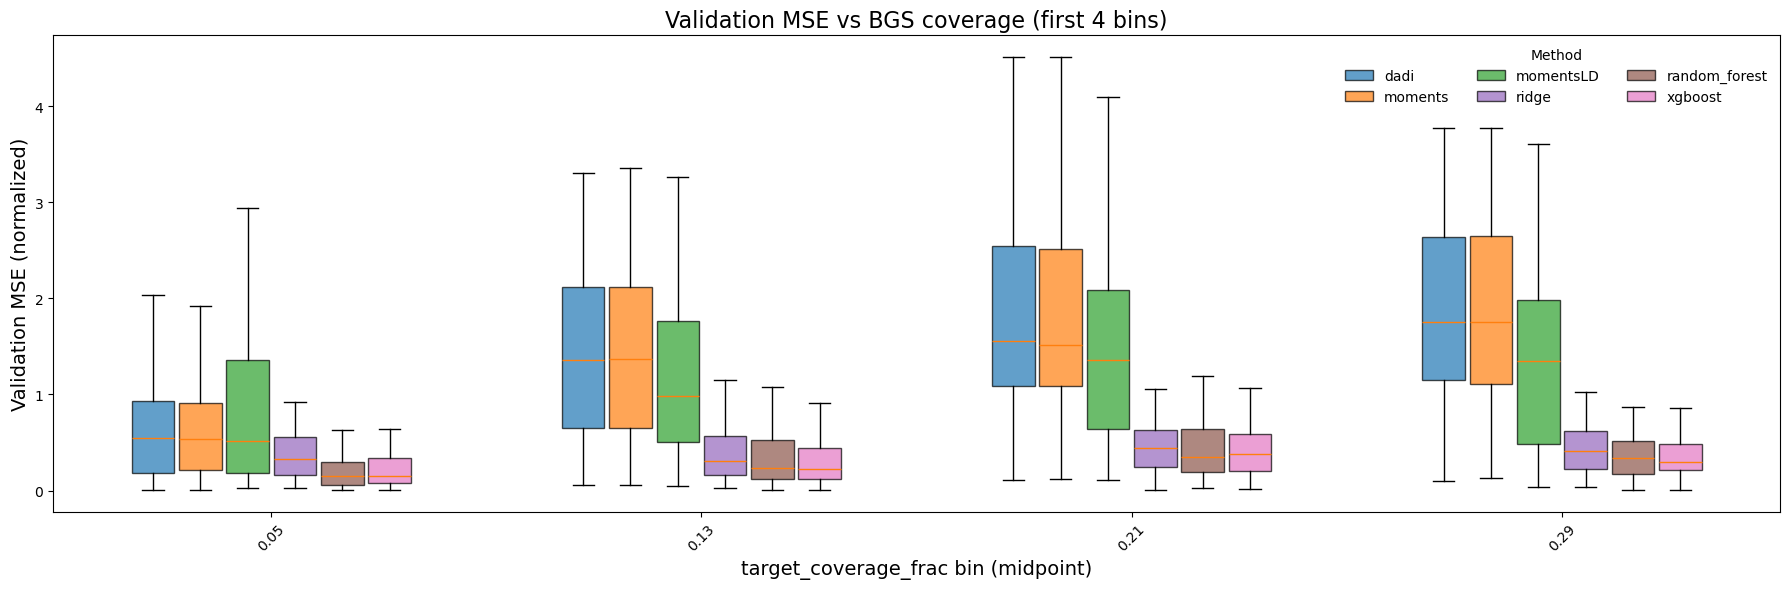

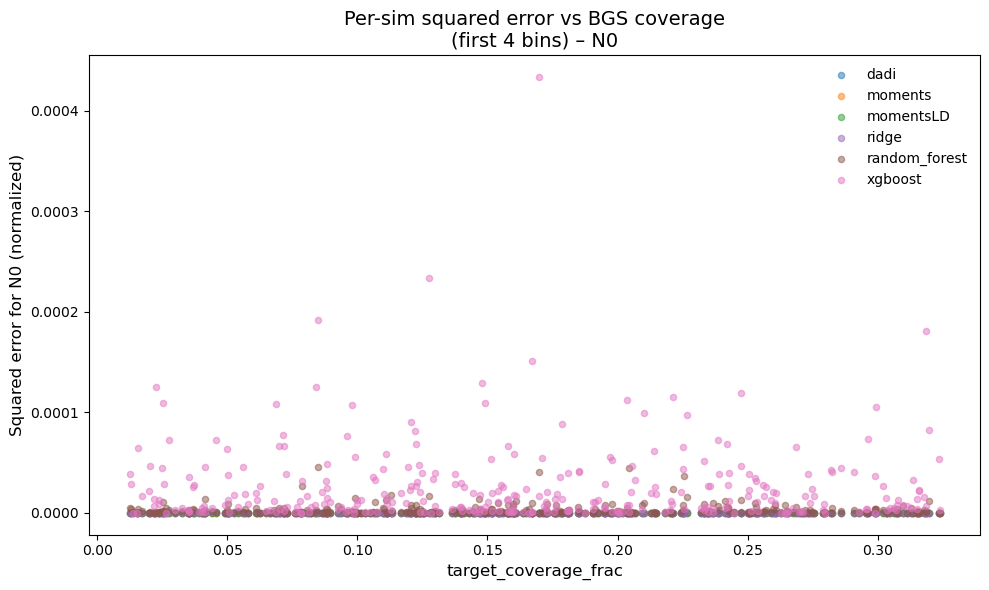

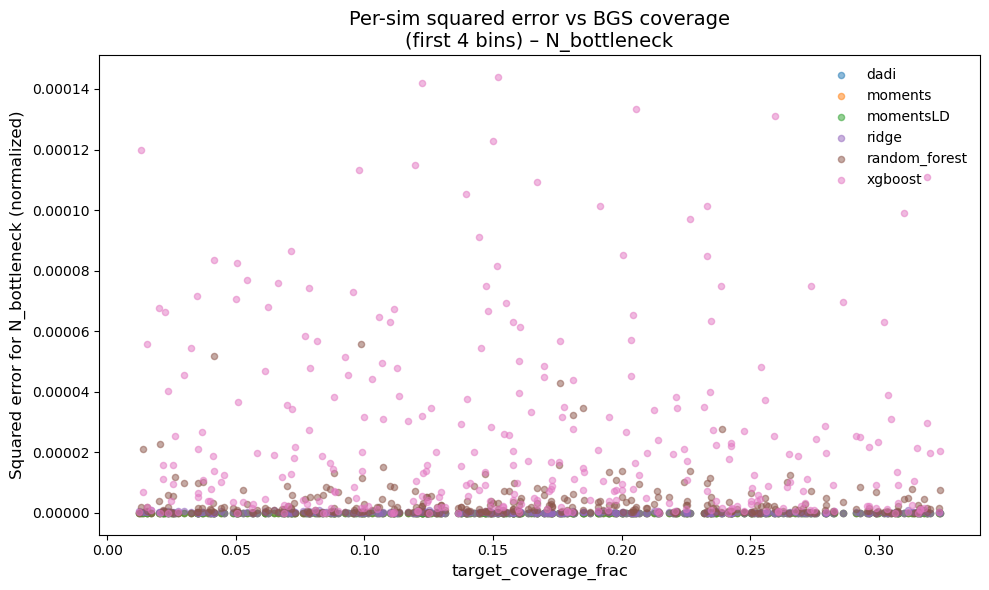

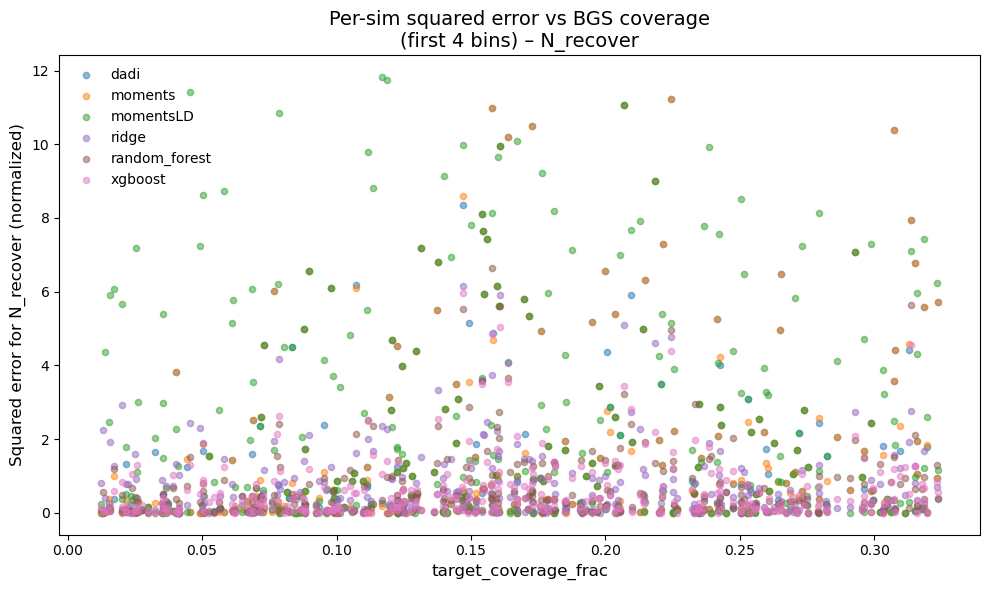

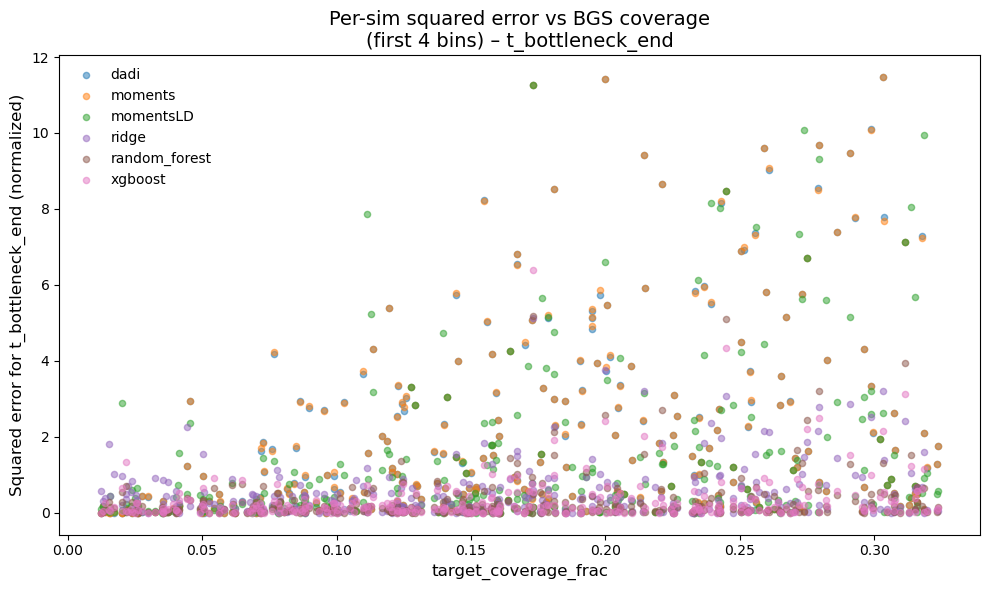

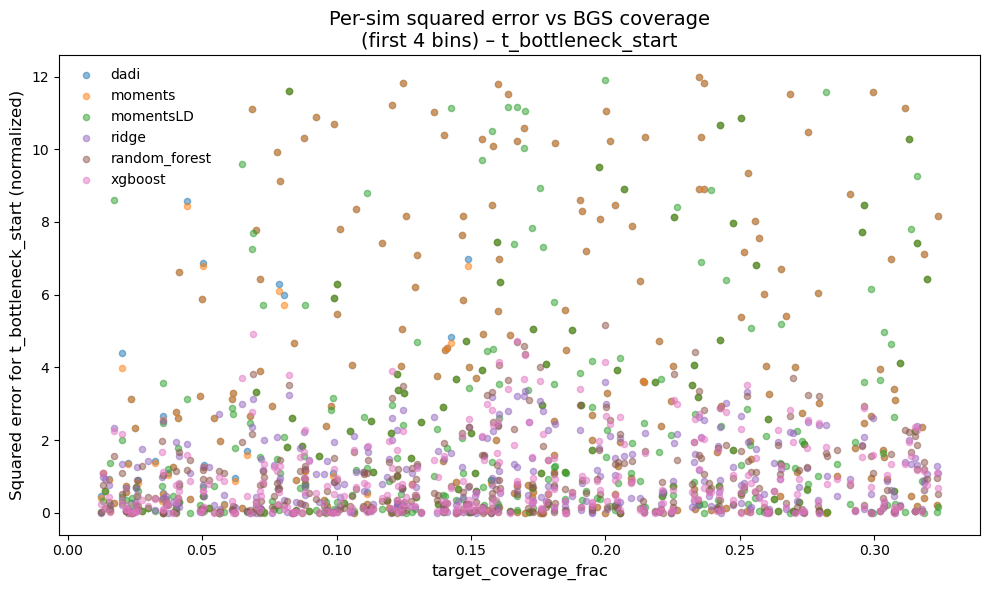

In [2]:
import json
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# ------------------------------------------------------------------------------
# 1. Load validation features to get sim IDs
# ------------------------------------------------------------------------------

model = 'bottleneck'
model_type = 'modeling_wo_FIM_wo_SFSresids'

val_feat_path = f"/home/akapoor/kernlab/Infer_Demography/experiments_BGS/{model}/{model_type}/datasets/validation_features.pkl"
with open(val_feat_path, "rb") as f:
    validation_features = pickle.load(f)

validation_sim_ids = validation_features.index.to_numpy()
print("Number of validation sims:", len(validation_sim_ids))

# ------------------------------------------------------------------------------
# 2. Extract BGS coverage (target_coverage_frac)
# ------------------------------------------------------------------------------
coverage_vals = []
for sid in validation_sim_ids:
    meta_path = Path(f"/home/akapoor/kernlab/Infer_Demography/experiments_BGS/{model}/simulations/{sid}/bgs.meta.json")
    if meta_path.exists():
        with open(meta_path) as fh:
            meta = json.load(fh)
        coverage_vals.append(meta.get("target_coverage_frac", np.nan))
    else:
        coverage_vals.append(np.nan)

coverage_vals = np.array(coverage_vals)

# ------------------------------------------------------------------------------
# 3. Recompute per-sim MSE for dadi / moments / momentsLD (normalized space)
# ------------------------------------------------------------------------------
datasets_dir = Path(f"/home/akapoor/kernlab/Infer_Demography/experiments_BGS/{model}/{model_type}/datasets")

with open(datasets_dir / "normalized_validation_features.pkl", "rb") as f:
    X_val = pickle.load(f)

with open(datasets_dir / "normalized_validation_targets.pkl", "rb") as f:
    y_val = pickle.load(f)

param_names = list(y_val.columns)
all_cols = X_val.columns

def tool_cols(tool, param):
    """All replicate columns for dadi/moments, or single for momentsLD."""
    pat = re.compile(rf"^{re.escape(tool)}_{re.escape(param)}(?:_rep_\d+)?$")
    return [c for c in all_cols if pat.match(c)]

def mse_for_tool(tool):
    """Per-simulation MSE (avg squared error across params)."""
    mse_list = []
    for sid in validation_sim_ids:
        se_sum, n = 0.0, 0
        for p in param_names:
            cols = tool_cols(tool, p)
            if not cols:
                continue
            preds = X_val.loc[sid, cols].to_numpy(float)
            preds = preds[~np.isnan(preds)]
            if preds.size == 0:
                continue
            pred_mean = preds.mean()
            true_val = float(y_val.loc[sid, p])
            se_sum += (pred_mean - true_val) ** 2
            n += 1
        mse_list.append(se_sum / n if n > 0 else np.nan)
    return np.array(mse_list, dtype=float)

mse_dadi      = mse_for_tool("dadi")
mse_moments   = mse_for_tool("moments")
mse_momentsLD = mse_for_tool("momentsLD")

# ------------------------------------------------------------------------------
# 4. Load ML models (ridge / RF / XGB) and compute per-sim MSE
# ------------------------------------------------------------------------------
def load_mse(path):
    with open(path, "rb") as f:
        obj = pickle.load(f)
    preds = obj["validation"]["predictions"]
    targs = obj["validation"]["targets"]
    return np.mean((preds - targs) ** 2, axis=1)

ridge_path = f"/home/akapoor/kernlab/Infer_Demography/experiments_BGS/{model}/{model_type}/linear_ridge/linear_mdl_obj_ridge.pkl"
rf_path    = f"/home/akapoor/kernlab/Infer_Demography/experiments_BGS/{model}/{model_type}/random_forest/random_forest_mdl_obj.pkl"
xgb_path   = f"/home/akapoor/kernlab/Infer_Demography/experiments_BGS/{model}/{model_type}/xgboost/xgb_mdl_obj.pkl"

mse_ridge = load_mse(ridge_path)
mse_rf    = load_mse(rf_path)
mse_xgb   = load_mse(xgb_path)

# ------------------------------------------------------------------------------
# 5. Unified DataFrame
# ------------------------------------------------------------------------------
df = pd.DataFrame({
    "sim_id": validation_sim_ids,
    "coverage": coverage_vals,
    "dadi": mse_dadi,
    "moments": mse_moments,
    "momentsLD": mse_momentsLD,
    "ridge": mse_ridge,
    "random_forest": mse_rf,
    "xgboost": mse_xgb,
})

df = df.dropna(subset=["coverage"]).reset_index(drop=True)
print("Rows in df after dropping NaN coverage:", len(df))

# also keep a mapping from sim_id -> index in validation arrays  # <<< NEW
sim_id_to_idx = {sid: i for i, sid in enumerate(validation_sim_ids)}  # <<< NEW

# ------------------------------------------------------------------------------
# 6. Discretize coverage into bins and plot *grouped* boxplots per model
# ------------------------------------------------------------------------------
n_bins = 12
bins = np.linspace(df["coverage"].min(), df["coverage"].max(), n_bins + 1)

df["cov_bin"] = pd.cut(df["coverage"], bins=bins, include_lowest=True)
bin_categories = df["cov_bin"].cat.categories

# --- ONLY USE THE FIRST FEW BGS BINS ---------------------------------------- #
max_bins_to_use = 4   # <<< NEW: number of BGS bins to keep (change as you like)

use_categories = bin_categories[:max_bins_to_use]
df = df[df["cov_bin"].isin(use_categories)].copy()
df["cov_bin"] = df["cov_bin"].cat.remove_unused_categories()
bin_categories = df["cov_bin"].cat.categories  # update after filtering  # <<< NEW

# human-readable labels for x-axis: midpoints of bins
bin_labels = [f"{(cat.left + cat.right)/2:.2f}" for cat in bin_categories]
bin_positions = np.arange(len(bin_categories))  # base x for each bin

methods = ["dadi", "moments", "momentsLD", "ridge", "random_forest", "xgboost"]
titles  = ["dadi", "moments", "momentsLD", "ridge", "Random Forest", "XGBoost"]
colors  = {
    "dadi": "#1f77b4",
    "moments": "#ff7f0e",
    "momentsLD": "#2ca02c",
    "ridge": "#9467bd",
    "random_forest": "#8c564b",
    "xgboost": "#e377c2",
}

fig, ax = plt.subplots(figsize=(18, 6))

# width of each box for each method within a bin
width = 0.11

legend_handles = []

for i, method in enumerate(methods):
    groups = []
    positions = []

    for j, cat in enumerate(bin_categories):
        vals = df.loc[df["cov_bin"] == cat, method].dropna().values
        groups.append(vals)
        positions.append(bin_positions[j] + (i - len(methods)/2) * width + width/2)

    if all(len(g) == 0 for g in groups):
        continue

    bp = ax.boxplot(
        groups,
        positions=positions,
        widths=width * 0.9,
        showfliers=False,
        patch_artist=True,
        manage_ticks=False,
    )

    for patch in bp["boxes"]:
        patch.set_facecolor(colors[method])
        patch.set_alpha(0.7)

    legend_handles.append(bp["boxes"][0])
    bp["boxes"][0].set_label(method)

ax.set_xticks(bin_positions)
ax.set_xticklabels(bin_labels, rotation=45)
ax.set_xlabel("target_coverage_frac bin (midpoint)", fontsize=14)
ax.set_ylabel("Validation MSE (normalized)", fontsize=14)
ax.set_title(f"Validation MSE vs BGS coverage (first {max_bins_to_use} bins)", fontsize=16)

ax.legend(handles=legend_handles, title="Method", frameon=False, ncol=3)
fig.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# 7. Scatterplots per parameter vs coverage for those bins                    #
# ------------------------------------------------------------------------------
# For scatter plots, we want per-parameter squared error per sim, per method.

def load_preds_targets(path):  # <<< NEW
    with open(path, "rb") as f:
        obj = pickle.load(f)
    preds = obj["validation"]["predictions"]
    targs = obj["validation"]["targets"]
    return preds, targs

# classical tools (dadi/moments/momentsLD): compute per-param SE arrays  # <<< NEW
def param_se_for_tool(tool, param):
    se = np.full(len(validation_sim_ids), np.nan, dtype=float)
    for idx, sid in enumerate(validation_sim_ids):
        cols = tool_cols(tool, param)
        if not cols:
            continue
        preds = X_val.loc[sid, cols].to_numpy(float)
        preds = preds[~np.isnan(preds)]
        if preds.size == 0:
            continue
        pred_mean = preds.mean()
        true_val = float(y_val.loc[sid, param])
        se[idx] = (pred_mean - true_val) ** 2
    return se

classical_se = {tool: {} for tool in ["dadi", "moments", "momentsLD"]}
for tool in classical_se.keys():
    for p in param_names:
        classical_se[tool][p] = param_se_for_tool(tool, p)

# ML models: per-param SE from prediction matrices  # <<< NEW
ridge_preds, ridge_targs = load_preds_targets(ridge_path)
rf_preds,    rf_targs    = load_preds_targets(rf_path)
xgb_preds,   xgb_targs   = load_preds_targets(xgb_path)

ml_se = {
    "ridge": (ridge_preds - ridge_targs) ** 2,
    "random_forest": (rf_preds - rf_targs) ** 2,
    "xgboost": (xgb_preds - xgb_targs) ** 2,
}

methods_for_scatter = ["dadi", "moments", "momentsLD", "ridge", "random_forest", "xgboost"]

# sims that are in the first few bins only (same subset as df)  # <<< NEW
df_sim_ids = df["sim_id"].to_numpy()
df_cov     = df["coverage"].to_numpy()

# For convenience, get indices into validation arrays for those sims
df_indices = np.array([sim_id_to_idx[sid] for sid in df_sim_ids])

for param_idx, param in enumerate(param_names):
    plt.figure(figsize=(10, 6))
    for method in methods_for_scatter:
        if method in ml_se:  # ridge / RF / XGB
            se_full = ml_se[method][:, param_idx]
        else:  # dadi / moments / momentsLD
            se_full = classical_se[method][param]

        se_vals = se_full[df_indices]
        mask = ~np.isnan(se_vals)

        if not np.any(mask):
            continue

        plt.scatter(
            df_cov[mask],
            se_vals[mask],
            alpha=0.5,
            s=20,
            label=method,
            color=colors[method],
        )

    plt.xlabel("target_coverage_frac", fontsize=12)
    plt.ylabel(f"Squared error for {param} (normalized)", fontsize=12)
    plt.title(f"Per-sim squared error vs BGS coverage\n(first {max_bins_to_use} bins) – {param}", fontsize=14)
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()


In [1]:
import pickle
with open('/home/akapoor/kernlab/Infer_Demography/experiments/split_migration/modeling/datasets/features_df.pkl', 'rb') as f:
    features_df = pickle.load(f)

In [2]:
features_df

,FIM_element_0,FIM_element_1,FIM_element_10,FIM_element_11,FIM_element_12,FIM_element_13,FIM_element_14,FIM_element_15,FIM_element_16,FIM_element_17,...,moments_m_CEU_YRI_rep_0,moments_m_CEU_YRI_rep_1,moments_m_CEU_YRI_rep_2,moments_m_CEU_YRI_rep_3,moments_m_CEU_YRI_rep_4,moments_m_YRI_CEU_rep_0,moments_m_YRI_CEU_rep_1,moments_m_YRI_CEU_rep_2,moments_m_YRI_CEU_rep_3,moments_m_YRI_CEU_rep_4
0,0.000045,1.420032e-05,-0.000030,0.000019,3242.272213,1021.352950,0.000003,2.457050e+12,2.690350e+12,-2806.234620,...,0.000004,0.000004,0.000004,0.000004,0.000004,6.424730e-05,6.424731e-05,6.424731e-05,6.424732e-05,6.424731e-05
1,0.000042,2.327760e-04,-0.002332,0.030915,105459.767645,-1147.975329,-0.003582,5.154632e+11,7.156486e+10,-11879.975512,...,0.000078,0.000078,0.000078,0.000078,0.000078,5.969801e-05,5.969803e-05,5.969800e-05,5.969800e-05,5.969803e-05
2,0.000127,1.072727e-05,0.000004,0.000051,1948.565599,3.584579,0.000005,4.943166e+11,4.548473e+11,-537.777459,...,0.000014,0.000014,0.000014,0.000014,0.000014,9.367839e-05,9.367837e-05,9.367840e-05,9.367837e-05,9.367840e-05
3,0.000065,9.506752e-06,0.000006,0.000020,1994.037872,397.266773,0.000005,7.207393e+11,4.659766e+11,-565.421882,...,0.000051,0.000051,0.000051,0.000051,0.000051,7.182595e-05,7.182588e-05,7.182590e-05,7.182602e-05,7.182589e-05
4,0.000059,5.342537e-05,-0.001500,0.000092,2589.303678,367.843367,-0.000136,2.195322e+11,1.014219e+11,-7853.164727,...,0.000100,0.000100,0.000100,0.000100,0.000100,5.839051e-05,5.839053e-05,5.839054e-05,5.839052e-05,5.839056e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.000057,5.364246e-05,-0.006528,0.000041,2202.243776,265.646407,-0.000039,6.469149e+11,2.722381e+11,-5788.781155,...,0.000013,0.000013,0.000013,0.000013,0.000013,4.498370e-05,4.498373e-05,4.498371e-05,4.498370e-05,4.498371e-05
4996,0.000053,5.366166e-06,-0.000026,0.000023,8013.112614,3474.238964,-0.000025,6.282076e+12,3.670963e+12,-22531.986376,...,0.000006,0.000006,0.000006,0.000006,0.000006,1.121750e-05,1.121748e-05,1.121750e-05,1.121752e-05,1.121747e-05
4997,0.000149,8.738446e-06,0.000012,0.015498,87792.760623,12503.399254,-0.003514,2.866096e+13,9.649564e+10,-20581.605683,...,0.000100,0.000100,0.000100,0.000100,0.000100,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08
4998,0.000361,1.580692e-07,0.000009,0.000486,7910.929461,2302.533061,-0.000063,2.051307e+11,7.740724e+10,-1905.738634,...,0.000073,0.000073,0.000073,0.000073,0.000073,3.340857e-05,3.340859e-05,3.340855e-05,3.340867e-05,3.340861e-05
